In [3]:
# ANNOTATION PROBLEMS
import pathlib
import json
import tqdm
import pandas as pd
disambig = set(pd.read_csv('../data/wikidata-20211122-disambig.txt', header=None)[0])
listpage = set(pd.read_csv('../data/wikidata-20211122-list.txt', header=None)[0])

ROOT = pathlib.Path('Mewsli-9+badent')

counts = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    refs = [
        ref
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ]
    
    counts[lang] = {
        'disambig': sum(1 for r in refs if r in disambig),
        'listpage': sum(1 for r in refs if r in listpage),
        'total': len(refs),
    }
pd.DataFrame(counts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


,en,ar,de,es,fa,ja,sr,ta,tr,nl
disambig,2751,201,1907,1923,5,605,773,28,164,565
listpage,259,4,76,105,0,54,7,1,5,16
total,79258,5964,64807,55431,515,34214,35536,2683,5661,11962


In [5]:
import pathlib
import glob
import json

import dawg
import tqdm
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

ROOT = pathlib.Path('Mewsli-9')

results = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    cache = {}
    def predict(sent, surface, wm):
        ref = cache.setdefault(surface, wm.get( surface.replace(' ','_') ))
        return ref or -1

    surface, pred, gold = zip(*[
        (surface, predict(text, surface, wm), ref)
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ])

    res = pd.DataFrame({
        avg: precision_recall_fscore_support(gold, pred, zero_division=0, average=avg)[:-1]
        for avg in ['micro','macro']
    }, index=['precision', 'recall', 'fscore']).unstack().T
    res.loc[('', 'support')] = len(gold)
    results[lang] = res

(pd.DataFrame(results).T.sort_values(('','support'))[::-1]
 .style.bar(vmin=0, vmax=1, color='lightblue').format('{:.2f}')
 .set_caption('Wikipedia Page Name Baseline')
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


# Rank analysis

In [25]:
import json, re, html, pathlib
from collections import Counter

import matplotlib.pyplot as plt

from minimel.normalize import normalize, SNOWBALL_LANG
code_lang = dict(SNOWBALL_LANG)
code_lang['fa'] = 'Persian'
code_lang['ja'] = 'Japanese'

def rank(wm, counts, surface, i, stem=None):
    for norm in normalize(surface, language=stem):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1 and ent_count.get('Q%s'%i):
            return ent_count['Q%s'%i], -1
        if ent_count.get('Q%s'%i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count['Q%s'%i], order.index('Q%s'%i)
    if wm.get(surface.replace(' ','_')) == i:
        return 1, -1
    return 0, None

total_counts = {}
ranks = {}
stem_ranks = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    # if lang not in ['ta','nl', 'tr']:
    #     continue
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    counttypes = []
    
    countfile = pathlib.Path(index).parent / 'count.min2.json'
    if not countfile.exists():
        continue
    counts = json.load(open(countfile))
    counttypes += [(counts, None, ranks)]
    
    stemfile = pathlib.Path(index).parent / f'count.min2.stem-{lang}.json'
    if not stemfile.exists():
        continue
    counttypes += [(json.load(open(stemfile)), lang, stem_ranks)]
    
    total_counts[lang] = Counter()
    for ec in counts.values():
        for e,c in ec.items():
            total_counts[lang][int(e.replace('Q',''))] += c
    
    for c, stem, r in counttypes:
        r[lang] = pd.DataFrame([
            (surface, ref, *rank(wm, c, surface, ref, stem=stem))
            for _, links, text in (l.split('\t') for l in file.open())
            for surface, ref in json.loads(links).items()
            if ref not in disambig
        ], columns=['surface', 'ref', 'count', 'rank'])
len(ranks), len(stem_ranks)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.15s/it]


(9, 9)

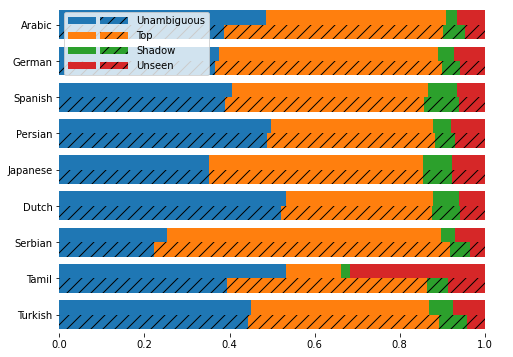

In [53]:
from matplotlib.legend_handler import HandlerTuple

def cat(x):
    return 'Unseen' if pd.isna(x) else ('Shadow' if x>0 else (' Top' if x==0 else '  Unambiguous'))

fig, ax = plt.subplots(figsize=(8,6))
pd.DataFrame({
    code_lang.get(l,l).title():r['rank'].apply(cat).value_counts() / len(r)
    for l,r in sorted(ranks.items())[::-1]
}).sort_index().T.plot.barh(ax=ax, stacked=True, width=.4, position=0)
x = pd.DataFrame({
    code_lang.get(l,l).title():r['rank'].apply(cat).value_counts() / len(r)
    for l,r in sorted(stem_ranks.items())[::-1]
}).sort_index().T.plot.barh(ax=ax, stacked=True, width=.4, position=1, hatch='//')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_ylim([-.5, len(ranks)-.5])
ax.legend(
    list(zip(handles[:4], handles[4:])), 
    [l.strip() for l in labels[:4]], 
    loc='upper left',
    handlelength = 6,
    handler_map={tuple: HandlerTuple(ndivide=None)})

In [ ]:
lang = 'nl'
r = ranks[lang]

In [11]:
# Unseen
r[r['count'] == 0].fillna(-1).value_counts().reset_index().head(20)

,surface,ref,count,rank,0
0,World Solar Challenge,14520244,0,-1.0,4
1,Nations League,29000951,0,-1.0,4
2,Abadi,5639013,0,-1.0,3
3,Le Pen,12927,0,-1.0,3
4,Trudeau,3099714,0,-1.0,3
5,VK.com,116933,0,-1.0,2
6,vale gieren,177856,0,-1.0,2
7,Odinga,57657,0,-1.0,2
8,NPB,2113973,0,-1.0,2
9,Amerikaanse presidentschap,45578,0,-1.0,2


In [12]:
# Shadow
r[r['rank'] > 0].fillna(-1).value_counts().reset_index().head(20)

,surface,ref,count,rank,0
0,May,264766,15,2.0,6
1,Openbaar Ministerie,11775750,312,1.0,6
2,Washington,61,1112,1.0,5
3,ESM,1130098,30,1.0,5
4,China,148,6406,1.0,5
5,Peter Madsen,2076849,10,1.0,5
6,Amerikaanse presidentsverkiezingen,699872,17,2.0,5
7,NPS,2564279,201,1.0,4
8,Groningen,752,6298,1.0,4
9,burgeroorlog,19686631,7,15.0,4


<AxesSubplot:>

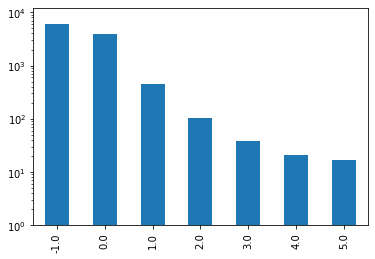

In [21]:
r['rank'].value_counts().head(7).plot.bar(logy=True, ylim=[1, r['rank'].value_counts().max()*2])

In [14]:
len(total_counts['nl'])

1146616

In [15]:
count = json.load(open('../wiki/nlwiki-20220301/count.min2.json'))

In [19]:
clean = json.load(open('../wiki/nlwiki-20220301/count.min2.clean8549.json'))
cleans = set([(k,int(v.replace('Q',''))) for k, vs in clean.items() for v in vs])
shadows = set([(n,e) for s,e in r[r['rank'] > 0][['surface','ref']].values for n in normalize(s)])
tops = set([(n,e) for s,e in r[r['rank'] == 0][['surface','ref']].values for n in normalize(s)])
print(len(cleans), 'clean candidates')
print( 'shadowed:', len(shadows), len(shadows & cleans) )
print( '     top:', len(tops), len(tops & cleans) )
pd.DataFrame([(s,e, count[s][f'Q{e}']) for s,e in shadows - cleans], columns=['s','e','c']).sort_values('c')[::-1]

18549 clean candidates
shadowed: 544 214
     top: 2001 459


,s,e,c
241,groningen,17937,266
132,leeuwarden,17944,184
223,lijk,48422,173
251,zeeland,2262442,160
194,netwerk,2415677,150
...,...,...,...
243,sanders,359442,2
246,ortega,57402,2
139,staatsgreep,25906338,2
130,klimaatakkoord,15715792,2


In [123]:
count['may']

{'Q264766': 15,
 'Q14641679': 8,
 'Q1860083': 8,
 'Q2453332': 2,
 'Q6796582': 11,
 'Q226158': 2,
 'Q1287363': 12,
 'Q648417': 23,
 'Q449758': 3,
 'Q2390046': 6,
 'Q15873': 79}

In [124]:
clean['may']

{'15873': 81, '264766': 5}

<AxesSubplot:>

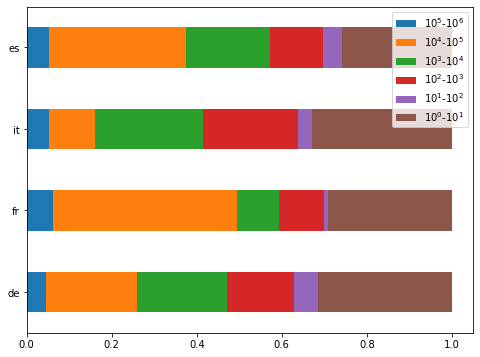

In [102]:
from numpy import log10
def freq_bins(l, r):
    return (
        r.merge(pd.Series(total_counts[l]).rename('total'), left_on='ref', right_index=True, how='left')['total'].fillna(1)
        .apply(lambda x: f'$10^{int(log10(x))}$-$10^{int(log10(x)+1)}$').value_counts()
    )
pd.DataFrame({
    l:freq_bins(l, r) / len(r)
    for l,r in ranks.items()
})[::-1].T.plot.barh(stacked=True, figsize=(8,6))